In [75]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


TIME = 52 # number of weeks

data_time = pd.read_csv("/home/physiologie/time_series/data/OGD_gest_kalwo_GEST_KALWOCHE_100.csv", delimiter = ";")
data_time["Gender"] = [0 if i == "C11-1" else 1 for i in data_time["C-C11-0"]] # C11-1 --> 
data_time["Year"] = [i[-6:-2] for i in data_time["C-KALWOCHE-0"]]
data_time["Kalenderweek"] = [i[-2:] for i in data_time["C-KALWOCHE-0"]]
data_time["Year_kal"] = [i[-6:] for i in data_time["C-KALWOCHE-0"]]
data_time["Date"] = [str(i[-6:-2]) + "-" + str(i[-2:]) for i in data_time["C-KALWOCHE-0"]]
data_time["Date"] = [datetime.strptime(i + '-0', "%Y-%W-%w") for i in data_time["Date"]]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39214 entries, 0 to 39213
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   C-KALWOCHE-0   39214 non-null  object        
 1   C-B00-0        39214 non-null  object        
 2   C-ALTERGR65-0  39214 non-null  object        
 3   C-C11-0        39214 non-null  object        
 4   F-ANZ-1        39214 non-null  int64         
 5   Gender         39214 non-null  int64         
 6   Year           39214 non-null  object        
 7   Kalenderweek   39214 non-null  object        
 8   Year_kal       39214 non-null  object        
 9   Date           39214 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 3.0+ MB


In [93]:
# bundesländer: 1: Burgenland, 2: Kärnten, 3: Niederösterreich, 4: Oberösterreich,5: Salzburg, 6: Steiermark, 7:
#Tirol, 8: Voralberg, 9: Wien 1: 0-64, 2: 65+
data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39214 entries, 0 to 39213
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   C-KALWOCHE-0   39214 non-null  object        
 1   C-B00-0        39214 non-null  object        
 2   C-ALTERGR65-0  39214 non-null  object        
 3   C-C11-0        39214 non-null  object        
 4   F-ANZ-1        39214 non-null  int64         
 5   Gender         39214 non-null  int64         
 6   Year           39214 non-null  object        
 7   Kalenderweek   39214 non-null  object        
 8   Year_kal       39214 non-null  object        
 9   Date           39214 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 3.0+ MB


In [90]:
# get gender differences

gender = pd.DataFrame(data_time.groupby(["Date","Gender"])["F-ANZ-1"].sum()).reset_index()
gender_male = gender[gender["Gender"] == 0]
gender_female = gender[gender["Gender"] == 1]
gender_male = gender_male.set_index("Date").drop("Gender", axis = 1)
gender_female = gender_female.set_index("Date").drop("Gender",axis = 1)

Text(0, 0.5, 'Death Tools')

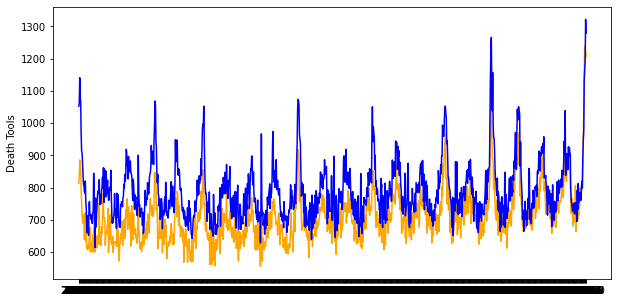

In [57]:
# plot the death rates 
fig,ax = plt.subplots(figsize = (10,5))
sns.lineplot(x = "Year_kal", y = "F-ANZ-1", data = gender_male, color = "orange")
sns.lineplot(x = "Year_kal", y = "F-ANZ-1", data = gender_female, color = "blue")
plt.xlabel("")
plt.ylabel("Death Tools")

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

<Figure size 432x288 with 0 Axes>

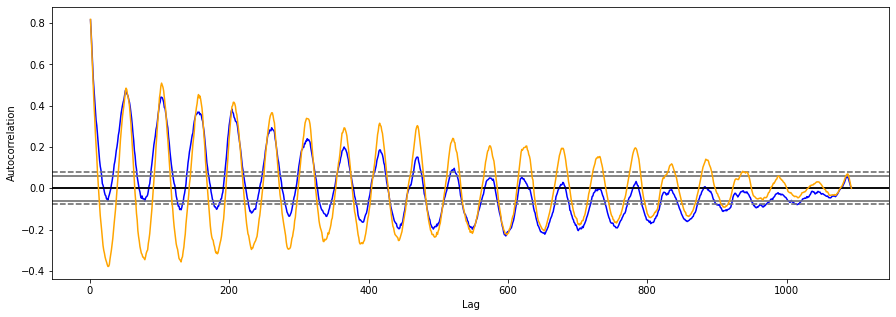

In [64]:
#autocorrelation plots between males and females

from pandas.plotting import autocorrelation_plot

plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
autocorrelation_plot(gender_male["F-ANZ-1"], ax=ax, color = "blue")
autocorrelation_plot(gender_female["F-ANZ-1"], ax=ax, color = "orange")

In [ ]:
# Get the seasonal trends

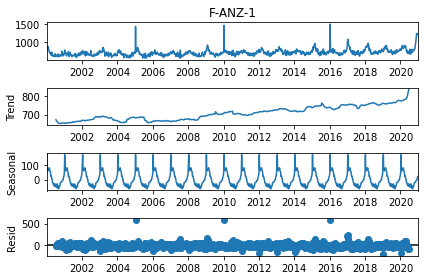

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(gender_male['F-ANZ-1'], 
                       model='additive', period = 52)

x = res.plot()

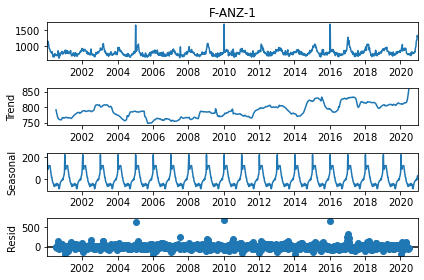

In [91]:
res_female = seasonal_decompose(gender_female['F-ANZ-1'], 
                       model='additive', period = 52)

y = res_female.plot()

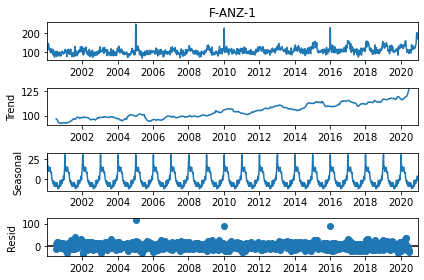

In [99]:
def bezirks_übersicht(df, choose, gender = None):
    # 
    
    if gender:
        bezirk = pd.DataFrame(df.groupby(["Date","C-B00-0","Gender"])["F-ANZ-1"].sum()).reset_index()
        bezirk_choosen = bezirk[bezirk["C-B00-0"] == choose]
        bezirk_choosen = bezirk_choosen.set_index("Date").drop("C-B00-0", axis = 1)
        bezirk_choosen_male = bezirk_choosen[bezirk_choosen["Gender"] == 0 ]
        bezirk_choosen_female = bezirk_choosen[bezirk_choosen["Gender"] == 1]
        return bezirk_choosen_male
    
    else:
        bezirk = pd.DataFrame(df.groupby(["Date","C-B00-0"])["F-ANZ-1"].sum()).reset_index()
        bezirk_choosen = bezirk[bezirk["C-B00-0"] == choose]
        bezirk_choosen = bezirk_choosen.set_index("Date").drop("C-B00-0", axis = 1)
        return bezirk_choosen
    

tirol_analysis = bezirks_übersicht(data_time, "B00-7")

bezirks_decompose = seasonal_decompose(tirol_analysis["F-ANZ-1"], period = 52)
z = bezirks_decompose.plot()

[<AxesSubplot:>]

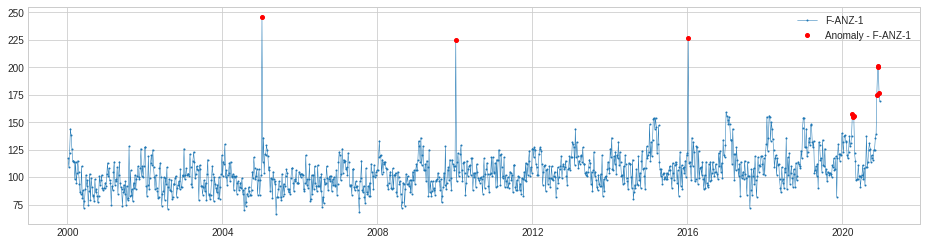

In [126]:
from adtk.visualization import plot
from adtk.detector import SeasonalAD
#from adtk import resample
trial = tirol_analysis.copy(deep = True)
s_train = trial.resample("1W").ffill()
seasonal_ad = SeasonalAD(freq = 52)
anomalies = seasonal_ad.fit_detect(s_train)
plot(s_train, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")